# Efecto de régimen de dosificación en PTA

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from keras.wrappers.scikit_learn import KerasRegressor

import plotly.express as px
import plotly.graph_objects as go

import numpy as np
import pandas as pd

from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.colors import Normalize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets

from google.colab import files

In [2]:
!pip install eli5
!pip install shap
import eli5
from eli5.sklearn import PermutationImportance
import shap

     |████████████████████████████████| 106 kB 5.5 MB/s 
     |████████████████████████████████| 371 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509231 sha256=dae3eaecd84eb22030882377581c4bd497c9aaa2e7345224c510ec5d814d3a42
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



## Preprocesamiento de los datos

In [3]:
data = pd.read_csv('datosFunRenal.csv')
data.head()

,Tipo,MIC,mn,g,CLCR,DD,II,Tinf
0,1,0.062500,1.0,1,90,1000,6,2
1,1,0.067033,1.0,1,90,1000,6,2
2,1,0.071894,1.0,1,90,1000,6,2
3,1,0.077108,1.0,1,90,1000,6,2
4,1,0.082701,1.0,1,90,1000,6,2


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29400 entries, 0 to 29399
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tipo    29400 non-null  int64  
 1   MIC     29400 non-null  float64
 2   mn      29400 non-null  float64
 3   g       29400 non-null  int64  
 4   CLCR    29400 non-null  int64  
 5   DD      29400 non-null  int64  
 6   II      29400 non-null  int64  
 7   Tinf    29400 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 1.8 MB


Se seleccionan a las variables `DD`, `ii`, `tinf`, `CLCR`, y `MIC`, como variables dependientes, se conoce por gráficos marginales que `ii`, `tinf`, y `CLCR` aportan poca información sobre el indicador PK-PD reportado en la columna `mn` (AUC/MIC >= 400).

In [5]:
X = data.loc[:, ['DD', 'II', 'Tinf', 'CLCR', 'MIC']]
X.MIC = np.log2(X.MIC) # Se convierte a logaritmo por simplicidad
y = data.mn

In [6]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

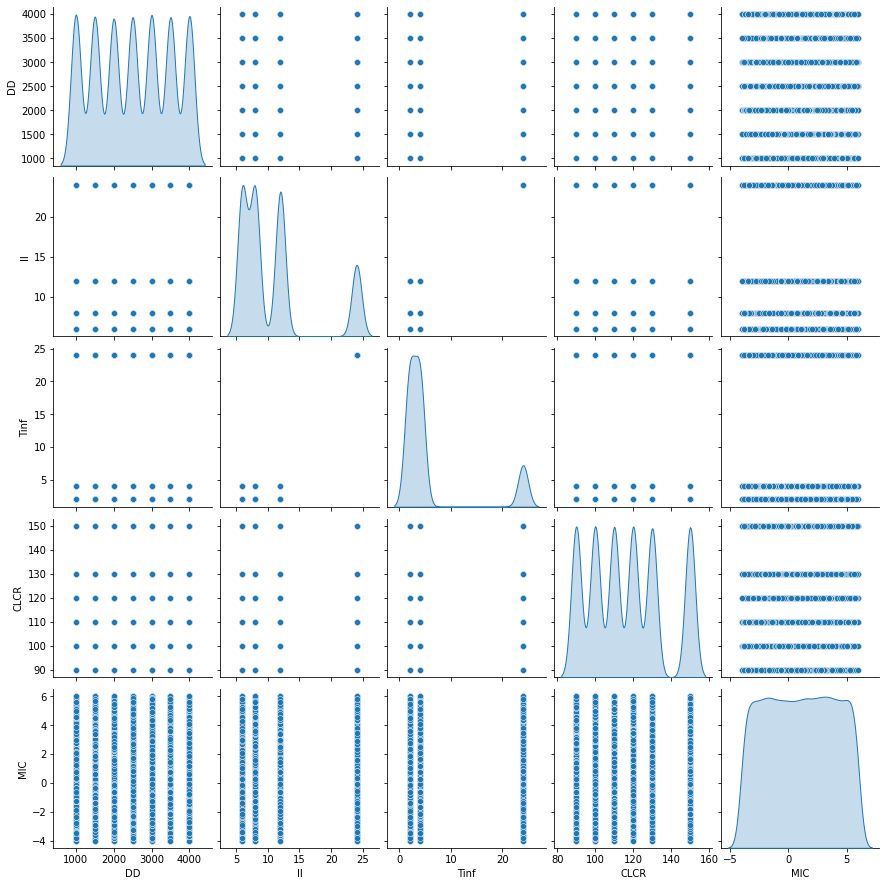

In [8]:
sns.pairplot(X_train, diag_kind='kde');

## Modelo
Ahora se especifica la configuración de varias red neuronales artificiales, mediante la librería `Keras`, y se busca la mejor mediante el error de predicción.

### Selección de modelos

In [9]:
def regresorKeras(nodosInicio = 5, listaOculta = []):
  # Inicio de modelo
  model = tf.keras.models.Sequential([normalizer])
  # Capa de entrada
  model.add(tf.keras.layers.Dense(nodosInicio, activation=tf.nn.relu, input_shape=(X_train.shape[1],), name = 'Entrada'))
  # Capas ocultas
  for nombre, nodos in enumerate(listaOculta):
    model.add(tf.keras.layers.Dense(nodos, activation=tf.nn.relu, name = 'Oculta_{0}'.format(nombre + 1)))
  
  # Capa de salida
  # Se selecciona una neurona de salida: indicador: AUC/MIC > 400
  # La capa de salida sólo permite valores de 0 a 1 se usa fun sigmoidea
  model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid, name = 'Salida')) 
  
  model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = 'mean_absolute_error', metrics = ['mae', 'mape', 'mean_squared_error'])
  return model; 

In [10]:
%%time
# Especificación de parada temprana
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, min_delta=1e-10)

# Especificación de arquitecturas ANN
estimatorA = KerasRegressor(build_fn=regresorKeras, batch_size=256, epochs=1000, validation_data=(X_test.values, y_test), verbose=0, callbacks = [callback], listaOculta = [5], nodosInicio = 5)
estimatorB = KerasRegressor(build_fn=regresorKeras, batch_size=256, epochs=1000, validation_data=(X_test.values, y_test), verbose=0, callbacks = [callback], listaOculta = [10], nodosInicio = 5)
estimatorC = KerasRegressor(build_fn=regresorKeras, batch_size=256, epochs=1000, validation_data=(X_test.values, y_test), verbose=0, callbacks = [callback], listaOculta = [10,10], nodosInicio = 5)
estimatorD = KerasRegressor(build_fn=regresorKeras, batch_size=256, epochs=1000, validation_data=(X_test.values, y_test), verbose=0, callbacks = [callback], listaOculta = [10,10,10], nodosInicio = 5)


CPU times: user 8.31 ms, sys: 0 ns, total: 8.31 ms
Wall time: 7.58 ms
Parser   : 223 ms


KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


In [11]:
%%time
# Guardar la historia de entrenamiento
historiaA = estimatorA.fit(X_train.values, y_train)
historiaB = estimatorB.fit(X_train.values, y_train)
historiaC = estimatorC.fit(X_train.values, y_train)
historiaD = estimatorD.fit(X_train.values, y_train)

CPU times: user 2min 16s, sys: 10.6 s, total: 2min 27s
Wall time: 2min


### Comparación entre modelos

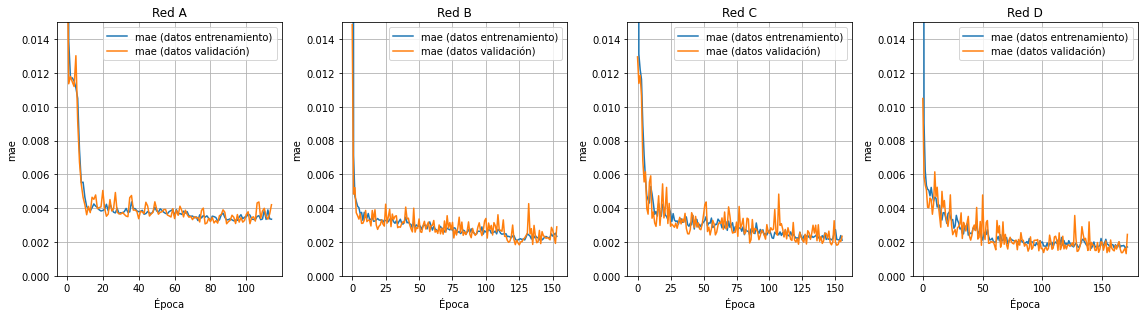

In [12]:
listaHistorias = [historiaA, historiaB, historiaC, historiaD]
listaNombre = ['Red {}'.format(i) for i in ['A', 'B', 'C', 'D']]

def verificacionHistoriaEntrenamiento(listaHistorias, listaNombre, indicador = 'MAE', coord_cart_y = [0, 0.015]):
  fig, axs = plt.subplots(1, 4, figsize = (16, 4.5))
  for ax, hist, nombre in zip(axs, listaHistorias, listaNombre):
    ax.plot(hist.history['{}'.format(indicador)], label = '{} (datos entrenamiento)'.format(indicador))
    ax.plot(hist.history['val_{}'.format(indicador)], label = '{} (datos validación)'.format(indicador))
    ax.axis(ymin = coord_cart_y[0], ymax = coord_cart_y[1])
    ax.set_xlabel('Época')
    ax.set_ylabel('{}'.format(indicador))
    ax.set_title(nombre)
    ax.legend()
    ax.grid(True)
  
  fig.set_tight_layout(True)

verificacionHistoriaEntrenamiento(listaHistorias, listaNombre, 'mae')
plt.savefig('./010_Error_Entrenamiento_ANN_MAE.pdf')

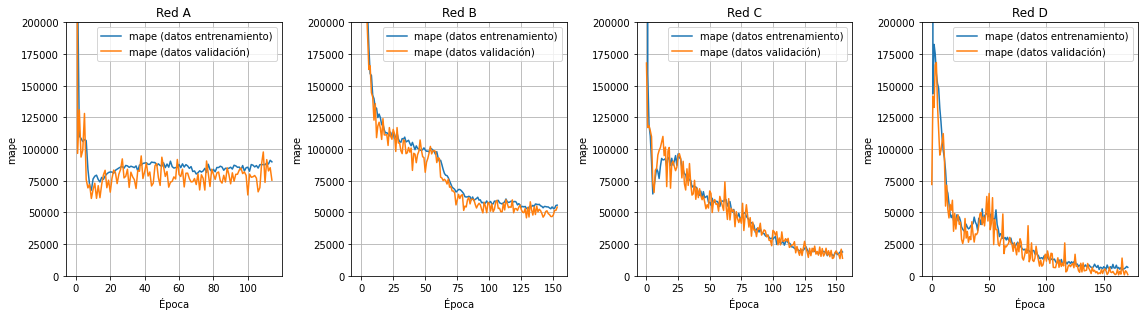

In [13]:
verificacionHistoriaEntrenamiento(listaHistorias, listaNombre, 'mape', coord_cart_y=[0, 2e5])
plt.savefig('./010_Error_Entrenamiento_ANN_MAPE.pdf')

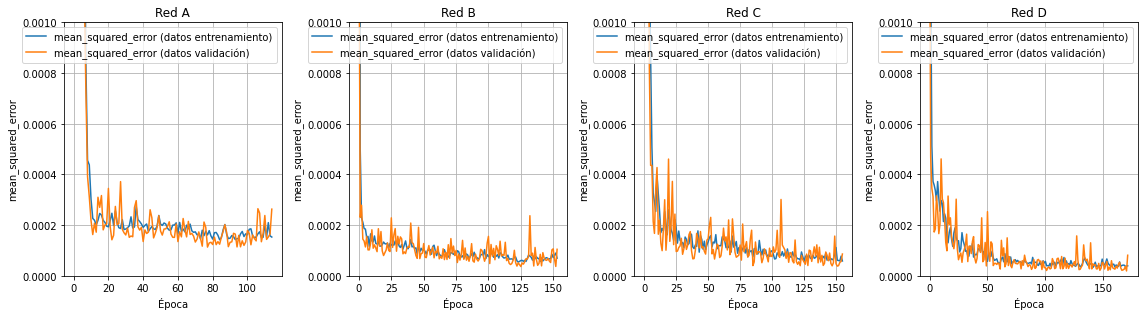

In [14]:
verificacionHistoriaEntrenamiento(listaHistorias, listaNombre, 'mean_squared_error', coord_cart_y=[0, 0.001])
plt.savefig('./010_Error_Entrenamiento_ANN_MSE.pdf')

In [15]:
listaRedes = ['A', 'B', 'C', 'D']
listaEstimadores = [eval("estimator{}".format(i)) for i in listaRedes]

listaPredicciones = list()

listaPredicciones.append( y_train.reset_index(drop=True).rename('Obs_Entren') )

for estim, nombre in zip(listaEstimadores, listaRedes):
  listaPredicciones.append( pd.Series(estim.predict(X_train), name = "Pred_Entren_{}".format(nombre)) )

listaPredicciones.append( y_test.reset_index(drop=True).rename('Obs_Prueba') )

for estim, nombre in zip(listaEstimadores, listaRedes):
  listaPredicciones.append( pd.Series(estim.predict(X_test), name = "Pred_Prueba_{}".format(nombre)) )

In [16]:
dfPredicciones = pd.concat(listaPredicciones, axis= 1)
dfPredicciones.head()

,Obs_Entren,Pred_Entren_A,Pred_Entren_B,Pred_Entren_C,Pred_Entren_D,Obs_Prueba,Pred_Prueba_A,Pred_Prueba_B,Pred_Prueba_C,Pred_Prueba_D
0,0.000,1.412634e-09,0.000001,2.853605e-32,2.196272e-24,0.000,6.148507e-05,0.000045,2.228066e-19,1.158422e-10
1,0.892,9.068383e-01,0.908589,9.107817e-01,8.716484e-01,0.000,8.271466e-08,0.000004,7.095685e-32,3.152998e-22
2,0.000,6.909283e-06,0.000019,4.901521e-24,1.639775e-13,1.000,9.999938e-01,1.000000,1.000000e+00,1.000000e+00
3,1.000,9.999996e-01,1.000000,1.000000e+00,1.000000e+00,0.029,3.360111e-02,0.029201,3.310558e-02,2.701557e-02
4,0.000,5.960823e-06,0.000021,7.269271e-26,1.981279e-15,0.000,7.837092e-05,0.000204,4.942124e-12,3.746430e-10


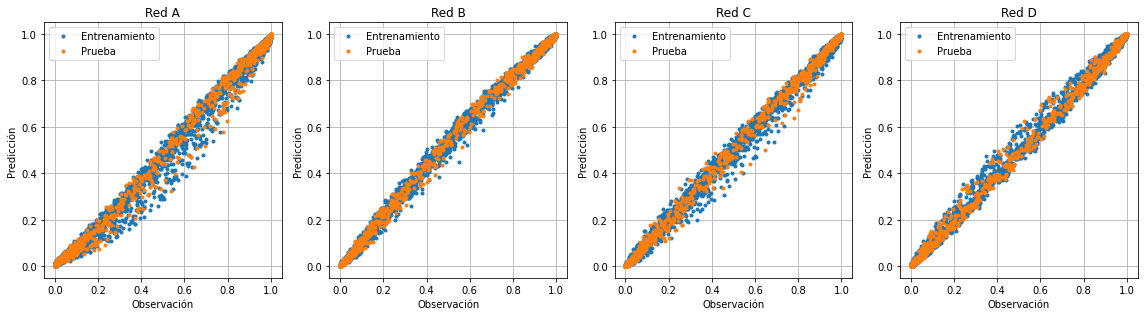

In [17]:
fig, axs = plt.subplots(1, 4, figsize = (16, 4.5))

for ax, title in zip(axs, listaRedes):
  ax.plot('Obs_Entren', 'Pred_Entren_{}'.format(title), '.', data = dfPredicciones, label='Entrenamiento')
  ax.plot('Obs_Prueba', 'Pred_Prueba_{}'.format(title), '.', data = dfPredicciones, label='Prueba')
  # ax.axis(ymin = 0, ymax = 0.015)
  ax.set_xlabel('Observación')
  ax.set_ylabel('Predicción')
  ax.set_title('Red {}'.format(title))
  ax.legend()
  ax.grid(True)

fig.set_tight_layout(True)
plt.savefig('./010_BondadAjuste_ANN.pdf')

In [18]:
df_erroresEntren = dfPredicciones.assign(
    Error_Entren_A = lambda df: df.Pred_Entren_A - df.Obs_Entren,
    Error_Entren_B = lambda df: df.Pred_Entren_B - df.Obs_Entren,
    Error_Entren_C = lambda df: df.Pred_Entren_C - df.Obs_Entren,
    Error_Entren_D = lambda df: df.Pred_Entren_D - df.Obs_Entren
)\
.melt(value_vars = ['Error_Entren_A', 'Error_Entren_B', 'Error_Entren_C', 'Error_Entren_D'])

df_erroresEntren[['_', 'tipo', 'modelo']] = df_erroresEntren['variable'].str.split('_',expand=True)

df_erroresPrueba = dfPredicciones.assign(
    Error_Prueba_A = lambda df: df.Pred_Prueba_A - df.Obs_Prueba,
    Error_Prueba_B = lambda df: df.Pred_Prueba_B - df.Obs_Prueba,
    Error_Prueba_C = lambda df: df.Pred_Prueba_C - df.Obs_Prueba,
    Error_Prueba_D = lambda df: df.Pred_Prueba_D - df.Obs_Prueba
)\
.melt(value_vars = ['Error_Prueba_A', 'Error_Prueba_B', 'Error_Prueba_C', 'Error_Prueba_D'])

df_erroresPrueba[['_', 'tipo', 'modelo']] = df_erroresPrueba['variable'].str.split('_',expand=True)

df_errores = pd.concat([df_erroresEntren, df_erroresPrueba])\
.loc[:, ['tipo', 'modelo', 'value']]\
.dropna(subset=['value'])

In [19]:
df_errores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117600 entries, 0 to 76439
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   tipo    117600 non-null  object 
 1   modelo  117600 non-null  object 
 2   value   117600 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.6+ MB


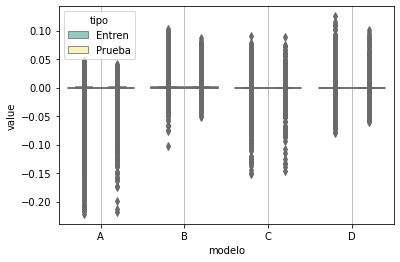

In [20]:
ax = sns.boxplot(x = 'modelo', y = 'value', hue = 'tipo', data =  , palette="Set3")
ax.xaxis.grid(True)

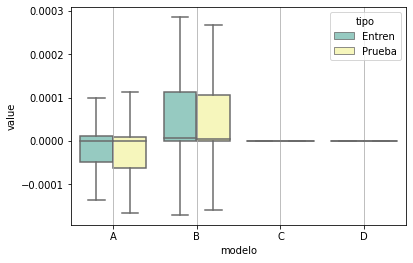

In [21]:
ax = sns.boxplot(x = 'modelo', y = 'value', hue = 'tipo', data = df_errores, palette="Set3", showfliers = False)
ax.xaxis.grid(True)

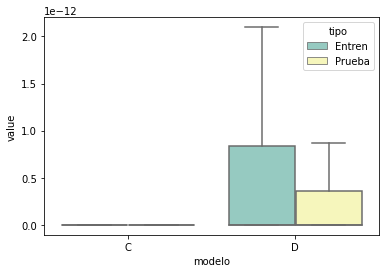

In [22]:
ax = sns.boxplot(x = 'modelo', y = 'value', hue = 'tipo', data = df_errores[df_errores.modelo.isin(['C', 'D'])], palette="Set3", showfliers = False)

In [23]:
df_errores.groupby(['tipo', 'modelo']).agg(
    MAE  = pd.NamedAgg(column = 'value', aggfunc = lambda x: np.mean(np.abs(x))),
    RMSE = pd.NamedAgg(column = 'value', aggfunc = lambda x: np.sqrt(np.mean(x**2)))
    ).reset_index().pivot(index = 'modelo', columns = 'tipo', values = ['MAE', 'RMSE'])

MAE                RMSE          
tipo      Entren    Prueba    Entren    Prueba
modelo                                        
A       0.003977  0.004208  0.016041  0.016219
B       0.002910  0.002897  0.010339  0.010225
C       0.002289  0.002342  0.008803  0.009271
D       0.002382  0.002450  0.008799  0.009005

In [24]:
## Seleccionar modelo C tiene el menor MAE y RMSE no muestra signos de sobreparametrización
estimator = estimatorD

In [25]:
 estimator.model.save('model_001')

import shutil
shutil.make_archive('model_001', 'zip', 'model_001')
files.download('/content/model_001.zip')

INFO:tensorflow:Assets written to: model_001/assets


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
#from tensorflow import keras
#model = keras.models.load_model('model_001.h5')

## Funciones de creación de gráficos

In [27]:
def expand_grid(x, y, xval = 'x', yval = 'y'):
    xG, yG = np.meshgrid(x, y) # Crear malla
    xG = xG.flatten() # Hacer malla 1D
    yG = yG.flatten() # Igual
    return pd.DataFrame({xval:xG, yval:yG})

In [28]:
def PTAColorScalePlotly(color1 = 'rgb(255,32,3)', color2 = 'rgb(3,148, 252)', umbral=0.85):
  return [(0.00, color1), (umbral, color1), (umbral, color2), (1.00, color2)]

In [29]:
# sampleDF = expand_grid(np.linspace(-6, 6), np.linspace(15, 30), xval = 'MIC', yval = 'DD')
# sampleDF['ii'] = 6
# sampleDF['tinf'] = 2
# sampleDF['CLCR'] = 120
# sampleDF = sampleDF[['DD', 'ii', 'tinf', 'CLCR', 'MIC']]

In [30]:
objetoDict = {
  'MIC': np.linspace(-6, 6),
  'DD': np.linspace(1500, 3000),
  'II': 6,
  'Tinf': 2,
  'CLCR': 120
}

ordenLista = ['DD', 'II', 'Tinf', 'CLCR', 'MIC']

def simularANN(variables, modelo, orden = ordenLista):
  dictArray  = [(i,k) for (i,k) in variables.items() if type(k) == np.ndarray]
  floatArray = [(i,k) for (i,k) in variables.items() if type(k) != np.ndarray]

  if len(dictArray) > 2:
    return
  
  sampleDF = expand_grid(dictArray[0][1], 
                        dictArray[1][1], 
                        xval = dictArray[0][0], 
                        yval = dictArray[1][0])

  for i in range(len(floatArray)):
    var, val = floatArray[i];
    sampleDF[var] = val

  sampleDF = sampleDF[orden]
  resultados = {'x': dictArray[0], 'y': dictArray[1], 'z': modelo.predict(sampleDF)}
  return resultados

In [31]:
DF = simularANN(objetoDict, estimator, ordenLista)

In [32]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": -6, "end": +6, "size": 1, "color":"white"},
        "y": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = DF['x'][1],
    y = DF['y'][1],
    z = DF['z'].reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, DF['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ))

fig.update_layout(
    title='Superficie de respuesta ANN - Vancomicina',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        "xaxis_title": "log<sub>2</sub>(MIC)",
        "yaxis_title": "Dosis diaria <br> (mg/día)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })

fig.show()

fig.write_html("011_superficiePTA_dosis_MIC.html")


In [36]:
import pickle
pickle.dump(fig, open("011_superficiePTA_dosis_MIC.pickle", 'wb'))

In [ ]:
def PTAColorScaleMatplotlib(color1 = "#ff2103", color2 = "#0394fc", umbral=0.85):
  cmap = ListedColormap([color1, color1, color2, color2])
  bounds = [0.0, umbral, 1.0]
  norm = BoundaryNorm(bounds, cmap.N)

  return {'cmap': cmap, 'bounds': bounds, 'norm': norm}

In [ ]:
def grafico3DSuperficie(x, y, z, newcmp, xlab = '', ylab = '', zlab = '', 
                        lim_opt = {'xlab': [-6, +6], 'ylab': [15,30], 'zlab': [0,1]}, 
                        view_init_opt = {'elev': 10, 'azim': 12}):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  
  x1, y1 = np.meshgrid(x, y)

  ax.plot_surface(x1, y1, z, cmap=newcmp, linewidth=0, antialiased=False)
  ax.set_xlim(lim_opt['xlab'][0], lim_opt['xlab'][1])
  ax.set_ylim(lim_opt['ylab'][0], lim_opt['ylab'][1])
  ax.set_zlim(lim_opt['zlab'][0], lim_opt['zlab'][1])
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_zlabel(zlab)
  ax.view_init(elev = view_init_opt['elev'], azim = view_init_opt['azim']);
  return fig;

In [ ]:
def grafico3DContorno(ax, x, y, z, cmap, xlab = '', ylab = '', title=''):
  
  x1, y1 = np.meshgrid(x, y)
  main = ax.contourf(x1, y1, z, levels = [0.0, 0.85, 1.00], cmap=cmap, 
                     #vmax=1, vmin=0
                     )
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)

  return main;

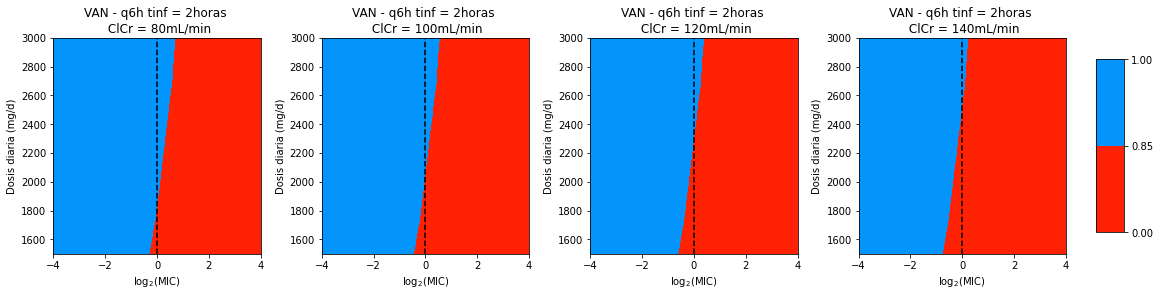

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(16,4), constrained_layout=True)
colscal = PTAColorScaleMatplotlib(umbral=0.85)

modelDict = {'MIC': np.linspace(-4, 4), 'DD': np.linspace(1500, 3000), 'II': 6, 'Tinf': 2, 'CLCR': 80}

# CLCR = 80
modelDict['CLCR'] = 80
df = simularANN(modelDict, estimator, ordenLista)
grafico3DContorno(ax[0], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                        '$\log_{2}{(\mathrm{MIC})}$', 'Dosis diaria (mg/d)', 'VAN - q6h tinf = 2horas \n ClCr = 80mL/min')

ax[0].vlines(0, 1500, 3000, linestyle='dashed')

# CLCR = 100
modelDict['CLCR'] = 100
df = simularANN(modelDict, estimator, ordenLista)
grafico3DContorno(ax[1], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                        '$\log_{2}{(\mathrm{MIC})}$', 'Dosis diaria (mg/d)', 'VAN - q6h tinf = 2horas \n ClCr = 100mL/min')
ax[1].vlines(0, 1500, 3000, linestyle='dashed')

# CLCR = 120
modelDict['CLCR'] = 120
df = simularANN(modelDict, estimator, ordenLista)
grafico3DContorno(ax[2], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                        '$\log_{2}{(\mathrm{MIC})}$', 'Dosis diaria (mg/d)', 'VAN - q6h tinf = 2horas \n ClCr = 120mL/min')
ax[2].vlines(0, 1500, 3000, linestyle='dashed')

# CLCR = 140
modelDict['CLCR'] = 140
df = simularANN(modelDict, estimator, ordenLista)
grafico3DContorno(ax[3], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                        '$\log_{2}{(\mathrm{MIC})}$', 'Dosis diaria (mg/d)', 'VAN - q6h tinf = 2horas \n ClCr = 140mL/min')
ax[3].vlines(0, 1500, 3000, linestyle='dashed')

#fig.set_tight_layout(True)
fig.colorbar(cm.ScalarMappable(cmap=colscal['cmap'], norm=colscal['norm']), 
             ax = ax, location='right', shrink=0.8);

plt.savefig('012_superficiePTA_dosis_MIC_1.pdf')

## Relación de MIC y CLCR
Se evalúo la relación para CLCR frente a MIC; 

In [ ]:
df = simularANN({'MIC': np.linspace(-6, 6), 'CLCR': np.linspace(90,150),'II': 6, 'Tinf': 2, 'DD': 2000}, estimator, ordenLista)

In [ ]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": -6, "end": +6, "size": 1, "color":"white"},
        "y": {"show": True, "start": 90, "end": 150, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'].reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>CLCR</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly(),
    ))

fig.update_layout(
    title='Superficie de respuesta Vancomicina - PTA vs CLCR',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        "xaxis_title": "log<sub>2</sub>(MIC)",
        "yaxis_title": "CLCR <br> (mL/min)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })
fig.show()

fig.write_html("012_superficiePTA_CLCR_MIC.html")

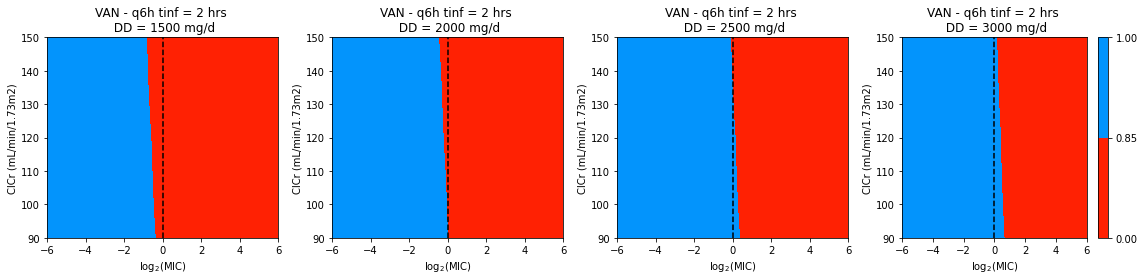

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(16,4))

colscal = PTAColorScaleMatplotlib(umbral=0.85)
# Cambio de la dosis diaria
for i,j in enumerate([1500, 2000, 2500, 3000]):
  df = simularANN({'MIC': np.linspace(-6, 6), 'CLCR': np.linspace(90, 150), 'II': 6, 'Tinf': 2, 'DD': j}, estimator, ordenLista)
  grafico3DContorno(ax[i], df['x'][1], df['y'][1], df['z'].reshape((50, 50)), colscal['cmap'], 
                          '$\log_{2}{(\mathrm{MIC})}$', 'ClCr (mL/min/1.73m2)', 'VAN - q6h tinf = 2 hrs \n DD = {0} mg/d'.format(j))
  ax[i].vlines(0, 90, 150, linestyle='dashed')

plt.colorbar(cm.ScalarMappable(cmap=colscal['cmap'], norm=colscal['norm']));
fig.set_tight_layout(True)
plt.savefig('013_superficiePTA_CLCR_MIC.pdf')

## Relación de Dosis y CLCR a MIC = 0.0625

In [ ]:
MIC_c = np.linspace(-1, +1, 20)

df = []
for i,j in enumerate(MIC_c):
  sim = simularANN({'DD': np.linspace(1500, 3000), 'CLCR': np.linspace(90, 150), 'II': 6, 'Tinf': 2, 'MIC': j}, estimator, ordenLista)
  df.append(sim)

In [ ]:
frameList = []

for i in range(len(df)):
  frame =  go.Frame(data=go.Surface(
              contours = {
                  "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
                  "y": {"show": True, "start": 90, "end": 150, "size": 10, "color":"white"},
                  "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
              },
              x = df[i]['x'][1],
              y = df[i]['y'][1],
              z = df[i]['z'].reshape((50, 50)), 
              customdata = [i for i in map(lambda m: 2**m, df[i]['x'][1])],
              hovertemplate = '<b>Dosis</b>: %{x:.2f} <br><b>CLCR</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
              colorscale = PTAColorScalePlotly(),
              ), 
              layout = go.Layout(
                  title = 'Superficie de respuesta ANN - Dosis vs CLCR - MIC {:.3f} mg/L'.format(2**(MIC_c[i]))
              ))
  
  frameList.append(frame);

overflow encountered in double_scalars


In [ ]:
# df = simularANN({'DD': np.linspace(15, 30), 'CLCR': np.linspace(90, 150), 'ii': 6, 'tinf': 2, 'MIC': -1}, estimator, ordenLista)

fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "y": {"show": True, "start": 90, "end": 150, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df[0]['x'][1],
    y = df[0]['y'][1],
    z = df[0]['z'].reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, df[0]['x'][1])],
    hovertemplate = '<b>Dosis</b>: %{x:.2f} <br><b>CLCR</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly(), 
    cmin=0.0, cmax=1.0
    ), 
    frames = frameList,
    layout = go.Layout(
        title = 'Superficie de respuesta ANN - Dosis vs CLCR - MIC {:.3f} mg/L'.format(2**(MIC_c[0])),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Iniciar",
                          method="animate",
                          args=[None])]), 
                     ]
    ))

fig.update_layout(
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": 1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},        
        'zaxis': {'range': [0, 1]},
        "xaxis_title": "Dosis (mg/d)",
        "yaxis_title": "CLCR <br> (mL/min)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })

# fig.data[0].update(zmin=0.0, zmax=1.0)

fig.show()

fig.write_html("014_superficiePTA_CLCR_Dosis.html")

overflow encountered in double_scalars


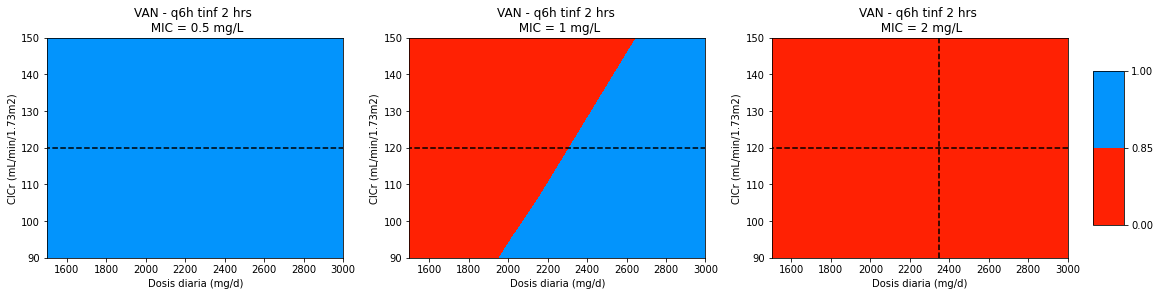

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(16,4), constrained_layout=True)

colscal = PTAColorScaleMatplotlib(umbral=0.85)
# Cambio de la dosis diaria
dosisOptima = [1000, 1150, 2350]

for i,j in enumerate([-1, 0, +1]):
  df = simularANN({'DD': np.linspace(1500, 3000, 200), 'CLCR': np.linspace(90, 150, 200), 'II': 6, 'Tinf': 2, 'MIC': j}, estimator, ordenLista)
  
  grafico3DContorno(ax[i], df['x'][1], df['y'][1], df['z'].reshape((200, 200)), colscal['cmap'], 
                          'Dosis diaria (mg/d)', 'ClCr (mL/min/1.73m2)', 'VAN - q6h tinf 2 hrs \n MIC = {0} mg/L'.format(2**j))
  ax[i].set_xlim(1500, 3000)
  ax[i].vlines(dosisOptima[i], 90, 150, linestyle='dashed')
  ax[i].hlines(120, 1000, 4000, linestyle='dashed')

plt.colorbar(cm.ScalarMappable(cmap=colscal['cmap'], norm=colscal['norm']), location='right', shrink=0.7);
#fig.set_tight_layout(True)

plt.savefig('015_superficiePTA_CLCR_Dosis.pdf')

## Relación de Dosis y Tiempo de infusión a MIC = 1

In [ ]:
df = simularANN({'DD': np.linspace(1500, 3000, 200), 'Tinf': np.linspace(2, 24, 200), 'II': 24, 'CLCR': 120, 'MIC': 0}, estimator, ordenLista)

In [ ]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": 1500, "end": 3000, "size": 500, "color":"white"},
        "y": {"show": True, "start": 2, "end": 24, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'].reshape((200, 200)), 
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>Dosis</b>: %{x:.2f} <br><b>T<sub>inf</sub></b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly(),
    cmin = 0, cmax = 1
    ))

fig.update_layout(
    title='Superficie de respuesta ANN - Dosis vs T<sub>inf</sub> - MIC: 1 - CLCR: 120mL/min - II: 24h',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        'zaxis': {'range': [0, 1]},
        "xaxis_title": "Dosis (mg/d)",
        "yaxis_title": "T<sub>inf</sub> <br> (hrs)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })
fig.show()

fig.write_html("016_superficiePTA_Dosis_TINF.html")

overflow encountered in double_scalars


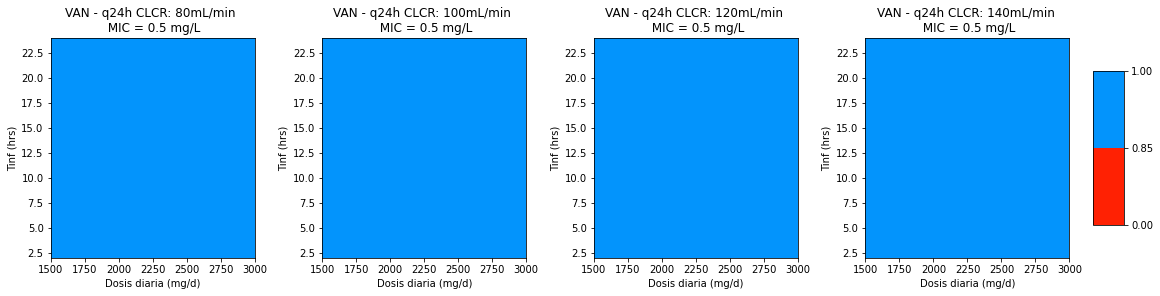

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(16,4), constrained_layout=True)

# Cambio de la dosis diaria
#dosisOptima = [16, 22.5, 42]

colscal = PTAColorScaleMatplotlib(umbral=0.85)

for i,j in enumerate([80, 100, 120, 140]):
  df = simularANN({'DD': np.linspace(1500, 3000, 200), 'Tinf': np.linspace(2, 24, 200), 'II': 24, 'CLCR': j, 'MIC': -1}, estimator, ordenLista)
  
  g3D = grafico3DContorno(ax[i], df['x'][1], df['y'][1], df['z'].reshape((200, 200)), colscal['cmap'], 
                          'Dosis diaria (mg/d)', 'Tinf (hrs)', 'VAN - q24h CLCR: {0}mL/min \n MIC = {1} mg/L'.format(j, 2**-1))
  # ax[i].set_xlim(15, 30)
  # ax[i].vlines(dosisOptima[i], 90, 150, linestyle='dashed')
  # ax[i].hlines(120, 15, 30, linestyle='dashed')

plt.colorbar(cm.ScalarMappable(cmap=colscal['cmap'], norm=colscal['norm']), location='right', shrink=0.7);
#fig.set_tight_layout(True)

plt.savefig('017_superficiePTA_Dosis_TINF.pdf')

## Explicación de importancia de predictores

In [ ]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.4791 ± 0.0039,MIC
0.0705 ± 0.0012,DD
0.0151 ± 0.0004,CLCR
0.0001 ± 0.0000,II
0.0000 ± 0.0000,Tinf


In [ ]:
def f_wrapper(X):
    return estimator.predict(X).flatten()

X_train_summary = shap.kmeans(X_train, 20)

explainer = shap.KernelExplainer(f_wrapper, X_train_summary)

# Make plot with combined shap values
# The training set is too big so let's sample it. We get enough point to draw conclusions
X_train_sample = X_train.sample(400)
shap_values  = explainer.shap_values(X_train_sample)

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
from pickle import dump

In [ ]:
# shap.summary_plot(shap_values, X_train_sample,  
#                   color_bar_label='PTA: AUC/MIC >= 400', title = 'Impacto de predictores en PTA', show = False)

# fig, ax = plt.gcf(), plt.gca()

# ax.set_xlabel('Valor SHAP (impacto en indicador PK/PD)')
# #ax.set_title('Shap', fontdict={"size":10})
# plt.savefig('018_shapValuesPTA_AUCMIC.pdf')

# file = open('018_shapValuesPTA_AUCMIC', 'wb')
# dump(fig, file)
# file.close()

In [ ]:
# X_muestra
np.save("001_shape_values", shap_values)
X_train_sample.to_csv('001_Xtrain.csv', index=False)

In [ ]:
shap.plots.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
shap.plots.initjs()
shap.plots.force(explainer.expected_value, shap_values, X_train_sample,
                 feature_names=['DD', 'ii', 'tinf', 'CLCR', 'MIC'])

In [ ]:
files_to_download = [
 "/content/010_Error_Entrenamiento_ANN_MAE.pdf",
 "/content/010_Error_Entrenamiento_ANN_MAPE.pdf",
 "/content/010_Error_Entrenamiento_ANN_MSE.pdf",
 "/content/010_BondadAjuste_ANN.pdf",
 "/content/011_superficiePTA_dosis_MIC.html",
 "/content/011_superficiePTA_dosis_MIC.pickle",
 "/content/012_superficiePTA_CLCR_MIC.html",
 "/content/013_superficiePTA_CLCR_MIC.pdf",
 "/content/014_superficiePTA_CLCR_Dosis.html",
 "/content/015_superficiePTA_CLCR_Dosis.pdf",
 "/content/016_superficiePTA_Dosis_TINF.html",
 "/content/017_superficiePTA_Dosis_TINF.pdf",
 "/content/018_shapValuesPTA_AUCMIC.pdf",
 "/content/018_shapValuesPTA_AUCMIC"
 ]

[files.download(i) for i in files_to_download]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [ ]:
# fig, ax = plt.subplots(1,4, figsize=(16, 3), constrained_layout=True)
# n_levels = 30
# n = 200
# norma1 = Normalize(vmin=0, vmax=1, clip=True)


# modelDict = {'MIC': np.linspace(-4, 4, n), 'DD': np.linspace(1500, 3000, n), 'II': 6, 'Tinf': 2, 'CLCR': 80}
# vecCLCR = [80, 100, 120, 140]

# for i in range(4):
#   modelDict['CLCR'] = vecCLCR[i]
#   df = simularANN(modelDict, estimator, ordenLista)
  
#   x1, y1 = np.meshgrid(df['x'][1], df['y'][1])
#   main = ax[i].contourf(x1, y1, df['z'].reshape((n, n)), n_levels, cmap=colscal, norm = norma1, corner_mask = False)
#   # csil = ax[i].contour(x1, y1, df['z'].reshape((n, n)), levels=[0.85], linewidths=[2], linestyles=('-'))
  
#   ax[i].set_xlabel('$\log_{2}{(\mathrm{MIC})}$');  ax[i].set_ylabel('Dosis diaria (mg/d)')
#   ax[i].set_title('VAN - q6h tinf 2 hrs \n CLCR = {}mL/min'.format(vecCLCR[i]))
#   ax[i].vlines(0, 1500, 3000, linestyle='dashed')

No contour levels were found within the data range.
No contour levels were found within the data range.
No contour levels were found within the data range.


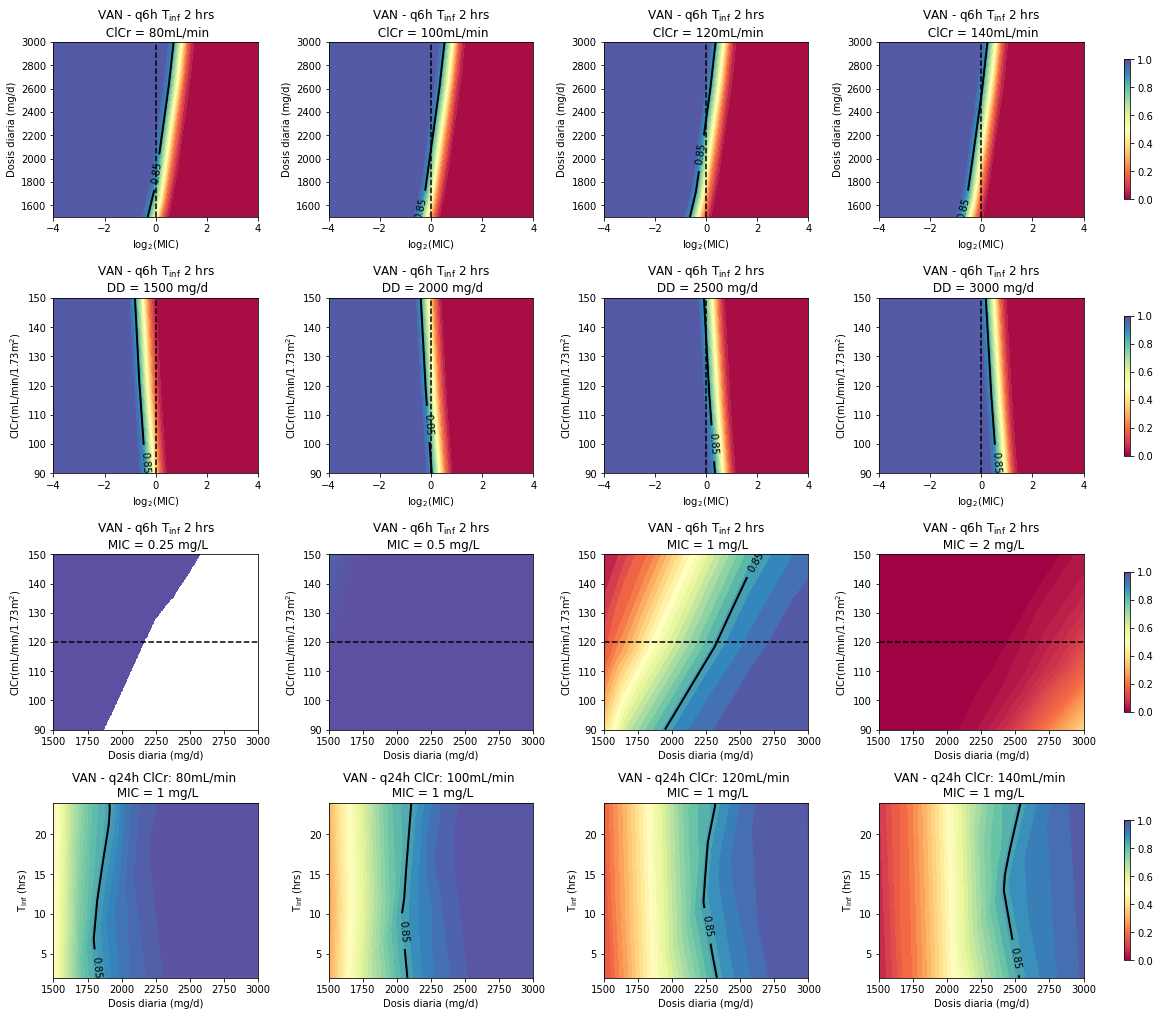

In [ ]:
fig, ax = plt.subplots(4,4, figsize=(16,14), constrained_layout=True)
colscal = 'Spectral'
norma1 = Normalize(vmin=0, vmax=1, clip=True)
n = 200
n_levels = 30

modelDict = {'MIC': np.linspace(-4, 4, n), 'DD': np.linspace(1500, 3000, n), 'II': 6, 'Tinf': 2, 'CLCR': 80}
vecCLCR = [80, 100, 120, 140]

for i in range(4):
  modelDict['CLCR'] = vecCLCR[i]
  df = simularANN(modelDict, estimator, ordenLista)
  
  x1, y1 = np.meshgrid(df['x'][1], df['y'][1])
  main = ax[0][i].contourf(x1, y1, df['z'].reshape((n, n)), n_levels, cmap=colscal, norm = norma1)
  csil = ax[0][i].contour(x1, y1, df['z'].reshape((n, n)), levels=[0.85], linewidths=[2], linestyles=('-'), colors='black')
  ax[0][i].clabel(csil, inline=True, fontsize=10, fmt='%1.2f')

  ax[0][i].set_xlabel('$\log_{2}{(\mathrm{MIC})}$');  ax[0][i].set_ylabel('Dosis diaria (mg/d)')
  ax[0][i].set_title('VAN - q6h $\mathrm{{T_{{inf}}}}$ 2 hrs \n ClCr = {}mL/min'.format(vecCLCR[i]))
  ax[0][i].vlines(0, 1500, 3000, linestyle='dashed')

modelDict = {'MIC': np.linspace(-4, 4, n), 'DD': 1000, 'II': 6, 'Tinf': 2, 'CLCR': np.linspace(90,150, n)}
vecDosis = [1500, 2000, 2500, 3000]

for i in range(4):
  modelDict['DD'] = vecDosis[i]
  df = simularANN(modelDict, estimator, ordenLista)
  
  x1, y1 = np.meshgrid(df['x'][1], df['y'][1])
  main = ax[1][i].contourf(x1, y1, df['z'].reshape((n,n)), n_levels, cmap=colscal, norm = norma1)
  csil = ax[1][i].contour(x1, y1, df['z'].reshape((n,n)), levels=[0.85], linewidths=[2], linestyles=('-'), colors = 'black')
  ax[2][i].clabel(csil, inline=True, fontsize=10, fmt='%1.2f')
  
  ax[1][i].set_xlabel('$\log_{2}{(\mathrm{MIC})}$');  ax[1][i].set_ylabel('$\mathrm{ClCr} (\mathrm{mL/min/1.73m}^2)$')
  ax[1][i].set_title('VAN - q6h $\mathrm{{T_{{inf}}}}$ 2 hrs \n DD = {} mg/d'.format(vecDosis[i]))
  ax[1][i].vlines(0, 90, 150, linestyle='dashed')

modelDict = {'MIC': -2, 'DD': np.linspace(1500, 3000, n), 'II': 6, 'Tinf': 2, 'CLCR': np.linspace(90, 150, n)}
vecMIC = [-2, -1, 0, 1]

for i in range(4):
  modelDict['MIC'] = vecMIC[i]
  df = simularANN(modelDict, estimator, ordenLista)
  
  x1, y1 = np.meshgrid(df['x'][1], df['y'][1])
  main = ax[2][i].contourf(x1, y1, df['z'].reshape((n,n)), n_levels, cmap=colscal, norm = norma1)
  csil = ax[2][i].contour(x1, y1, df['z'].reshape((n,n)), levels=[0.85], linewidths=[2], linestyles=('-'), colors='black')
  ax[2][i].clabel(csil, inline=True, fontsize=10, fmt='%1.2f')

  ax[2][i].set_xlabel('Dosis diaria (mg/d)'); ax[2][i].set_ylabel('$\mathrm{ClCr} (\mathrm{mL/min/1.73m}^2)$')
  ax[2][i].set_title('VAN - q6h $\mathrm{{T_{{inf}}}}$ 2 hrs \n MIC = {} mg/L'.format(2**(vecMIC[i])))
  ax[2][i].hlines(120, 1500, 3000, linestyle='dashed')

modelDict = {'MIC': 0, 'DD': np.linspace(1500, 3000, n), 'II': 6, 'Tinf': np.linspace(2, 24, n), 'CLCR': 80}
vecCLCR = [80, 100, 120, 140]

for i in range(4):
  modelDict['CLCR'] = vecCLCR[i]
  df = simularANN(modelDict, estimator, ordenLista)
  
  x1, y1 = np.meshgrid(df['x'][1], df['y'][1])
  main = ax[3][i].contourf(x1, y1, df['z'].reshape((n,n)), n_levels, cmap=colscal, norm = norma1)
  csil = ax[3][i].contour(x1, y1, df['z'].reshape((n,n)), levels=[0.85], linewidths=[2], linestyles=('-'), colors='black')
  ax[3][i].clabel(csil, inline=True, fontsize=10, fmt='%1.2f')

  ax[3][i].set_xlabel('Dosis diaria (mg/d)');  ax[3][i].set_ylabel('$\mathrm{T_{inf}}$ (hrs)')
  ax[3][i].set_title('VAN - q24h ClCr: {}mL/min \n MIC = 1 mg/L'.format(vecCLCR[i ]))
  #ax[3][i].hlines(120, 1000, 4000, linestyle='dashed')

fig.colorbar(cm.ScalarMappable(cmap=colscal), ax = ax[0], location='right', shrink=0.8);
fig.colorbar(cm.ScalarMappable(cmap=colscal), ax = ax[1], location='right', shrink=0.8);
fig.colorbar(cm.ScalarMappable(cmap=colscal), ax = ax[2], location='right', shrink=0.8);
fig.colorbar(cm.ScalarMappable(cmap=colscal), ax = ax[3], location='right', shrink=0.8);

plt.savefig('019_superficiePTA_dosis_MIC.pdf');

In [ ]:
files.download('/content/019_superficiePTA_dosis_MIC.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>